For this notebook, you will need to install the libraries `sentence-transformers`, `seaborn` and `matplotlib` and have an `OPENAI_API_KEY`.

In [1]:
!pwd

/c/projects/ask_my_resume/notebooks


In [2]:
import os
print(os.getcwd())
os.chdir("..")
print(os.getcwd())

C:\projects\ask_my_resume\notebooks
C:\projects\ask_my_resume


In [60]:
from rag_pipeline.rag import rag, vector_search, build_prompt, llm

from openai import OpenAI
from rag_pipeline.config import API_KEY, LLM_MODEL_DEFAULT

In [54]:
print(rag("What is the current company name", llm_model="llama-3.1-8b-instant"))

Based on the given context, the current company name is Securiti.


### Embeddings

We'll generate embeddings using the sentence transformers library

In [ ]:
pip install sentence-transformers

In [25]:
from sentence_transformers import SentenceTransformer
# Trained on real QA pairs from diverse domains & optimized for cosine similarity
# so ideal for RAG and Q&A-style tasks
model_name_qa = 'multi-qa-MiniLM-L6-cos-v1'  #'all-MiniLM-L6-v2'
model_qa = SentenceTransformer(model_name_qa)

# Smaller and slightly more general-pupose than multi-qa-*
model_name_all = 'all-MiniLM-L6-v2'
model_all = SentenceTransformer(model_name_all)

## Ground Truth Data

In [ ]:
# openai api
OPENAI_API_KEY=os.environ.get("OPENAI_API_KEY")
openai_client = OpenAI(
    api_key=OPENAI_API_KEY
)

In [9]:
import json

with open("data/resume.json", "r", encoding="utf-8") as f:
    document_raw = json.load(f)

In [10]:
prompt_template = """
You are an interviewer preparing for a behavioral or technical interview.
Your goal is to write 5 clear and complete questions that would directly elicit the following resume entry as an answer.
Only ask questions that can be directly answered using the provided entry. 
If the entry only includes company, job title, location, and dates, avoid asking technical or project-based questions.
Avoid copying exact phrases from the resume — the questions should sound natural, but their answers should be well covered by the entry.

section: {section}
entry: {text}

Provide the output in a JSON array only without using code blocks:
["question1", "question2", ..., "question5"]
""".strip()

In [12]:
doc = document_raw[5]
prompt = prompt_template.format(
        section=doc["metadata"]["section"],
        text=doc["text"]
    )
print(prompt)

You are an interviewer preparing for a behavioral or technical interview.
Your goal is to write 5 clear and complete questions that would directly elicit the following resume entry as an answer.
Only ask questions that can be directly answered using the provided entry. 
If the entry only includes company, job title, location, and dates, avoid asking technical or project-based questions.
Avoid copying exact phrases from the resume — the questions should sound natural, but their answers should be well covered by the entry.

section: Work Experience
entry: Iteratively improved model accuracy through prompt-formatted instructions and data augmentation techniques, utilizing AI copilots like Claude Code to automate data transformations.

Provide the output in a JSON array only without using code blocks:
["question1", "question2", ..., "question5"]


In [13]:
def generate_questions(doc):
    prompt = prompt_template.format(
        section=doc["metadata"]["section"],
        text=doc["text"]
    )

    response = openai_client.chat.completions.create(
        model='gpt-4o-mini',
        messages=[{"role": "user", "content": prompt}]
    )

    json_response = response.choices[0].message.content
    return json_response

In [14]:
from tqdm.auto import tqdm

In [17]:
print(len(document_raw))
type(document_raw)

19


list

In [18]:
19*5

95

In [ ]:
print(document_raw[5]) # 0, 6, 

print(generate_questions(document_raw[7]))

In [ ]:
results = {}

In [ ]:
for doc in tqdm(document_raw): 
    doc_id = doc['id']
    if doc_id in results:
        continue

    questions = generate_questions(doc)
    #print(questions)
    results[doc_id] = questions

In [ ]:
len(results)

In [61]:
import pandas as pd

In [ ]:
doc_id_to_section = {doc['id']:  doc["metadata"]["section"] for doc in document_raw}

# Flatten the results into a list of rows
rows = []
for doc_id, question_list in results.items():
    section = doc_id_to_section.get(doc_id, "Unknown")

     # Fix improperly stored stringified lists
    if isinstance(question_list, str):
        try:
            question_list = json.loads(question_list)
        except json.JSONDecodeError:
            print(f"Failed to decode questions for doc_id {doc_id}")
            continue
            
    for question in question_list:
        #print(question)
        rows.append({
            "question": question,
            "section": section,
            "doc_id": doc_id
        })

# Convert to DataFrame
df = pd.DataFrame(rows)

In [ ]:
len(rows)

In [ ]:
df.to_csv('data/ground_truth_data.csv', index=False)

In [ ]:
!head data/ground_truth_data.csv

In [19]:
import pandas as pd
df_ground_truth = pd.read_csv('data/ground_truth_data.csv')
df_ground_truth.head()

,question,section,doc_id
0,What is your current job title and where do yo...,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
1,Can you tell me about the location of your cur...,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
2,When did you start your current position?,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
3,Are you currently working as a Data Scientist?,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
4,What company are you employed with at the moment?,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9


In [20]:
ground_truth = df_ground_truth.to_dict(orient='records')
len(ground_truth)

95

In [81]:
#creating an index on document_raw to quickyl retrive the doc id answer from document_raw:
# builds a dictionary (lookup index) where  key is id value from each document, and value is the full document entry
doc_idx = {d["id"]: d for d in document_raw}

# # Now you can instantly access:
# doc_text = doc_idx['3e1e2fd4-45c5-47dd-b4e6-f68835f53f6d']["text"]
# doc_section = doc_idx['3e1e2fd4-45c5-47dd-b4e6-f68835f53f6d']["metadata"]["section"]
# doc_text

In [ ]:
ground_truth[4]['question']

In [ ]:
rag(ground_truth[4]['question'])

# Evaluate RAG

## Cosine Similarity

### llama-3.3-70b-versatile

In [ ]:
answers = {}

In [ ]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue
    #print(rec['question'])
    answer_llm = rag(rec['question'])
    doc_id = rec['doc_id']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'doc_id': doc_id,
        'question': rec['question'],
        'section': rec['section'],
    }

In [ ]:
len(answers)

In [ ]:
df_results_llama = pd.DataFrame(answers.values())#.sample(5).to_dict(orient='records')
#os.makedirs('data', exist_ok=True)
# df_results_llama.to_csv('data/results_llama-3.3-70b-versatile.csv', index=False)

In [22]:
df_results_llama = pd.read_csv('data/results_llama-3.3-70b-versatile.csv')

In [29]:
results_llama = df_results_llama.to_dict(orient='records')

In [32]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    # v_llm = model_qa.encode(answer_llm)
    # v_orig = model_qa.encode(answer_orig)
    
    v_llm = model_all.encode(answer_llm)
    v_orig = model_all.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [33]:
similarity = []

for record in tqdm(results_llama):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/95 [00:00<?, ?it/s]

In [31]:
df_results_llama['cosine_qa'] = similarity
df_results_llama['cosine_qa'].describe()
df_results_llama.groupby('section')['cosine_qa'].describe()

,count,mean,std,min,25%,50%,75%,max
section,,,,,,,,
Education,10.0,0.527080,0.228442,0.052174,0.425303,0.564721,0.702172,0.759555
Projects,10.0,0.655759,0.182994,0.381100,0.505373,0.655294,0.769978,0.923424
Skills,5.0,0.481072,0.115442,0.358570,0.359693,0.512676,0.582870,0.591552
Work Experience,70.0,0.594996,0.272041,-0.077712,0.532729,0.682576,0.785674,0.929522


In [112]:
# df_results_llama['cosine_all'] = similarity
# df_results_llama['cosine_all'].describe()
df_results_llama.groupby('section')['cosine_all'].describe()

,count,mean,std,min,25%,50%,75%,max
section,,,,,,,,
Education,10.0,0.510713,0.182568,0.090166,0.445921,0.543154,0.653294,0.685782
Projects,10.0,0.740273,0.143630,0.535940,0.633322,0.746957,0.850453,0.945555
Skills,5.0,0.491292,0.149535,0.284191,0.418129,0.485872,0.620672,0.647595
Work Experience,70.0,0.633545,0.267725,-0.061153,0.583262,0.727893,0.805798,0.926139


In [122]:
df_results_llama.drop(['cosine_qa','cosine_all'], axis=1)

,answer_llm,answer_orig,doc_id,question,section,cosine
0,"Your current job title is Data Scientist, and ...","Work Experience\nSecuriti, Karachi, Pakistan\t...",ae0142cf-58e4-408a-b2c3-950b9864f8e9,What is your current job title and where do yo...,Work Experience,0.782146
1,The location of your current workplace is Kara...,"Work Experience\nSecuriti, Karachi, Pakistan\t...",ae0142cf-58e4-408a-b2c3-950b9864f8e9,Can you tell me about the location of your cur...,Work Experience,0.760741
2,The candidate started their current position a...,"Work Experience\nSecuriti, Karachi, Pakistan\t...",ae0142cf-58e4-408a-b2c3-950b9864f8e9,When did you start your current position?,Work Experience,0.588890
3,"Yes, according to the resume, the candidate is...","Work Experience\nSecuriti, Karachi, Pakistan\t...",ae0142cf-58e4-408a-b2c3-950b9864f8e9,Are you currently working as a Data Scientist?,Work Experience,0.724143
4,The company you are employed with at the momen...,"Work Experience\nSecuriti, Karachi, Pakistan\t...",ae0142cf-58e4-408a-b2c3-950b9864f8e9,What company are you employed with at the moment?,Work Experience,0.582434
...,...,...,...,...,...,...
90,"According to the candidate's resume, the cours...","Courses: Machine Learning, Probability & Stati...",6997daaa-6c04-4f95-84f8-000586c93ed0,What courses did you take that are related to ...,Education,0.669786
91,"Based on the candidate's resume, the subject t...","Courses: Machine Learning, Probability & Stati...",6997daaa-6c04-4f95-84f8-000586c93ed0,Can you list some of the subjects you studied ...,Education,0.370050
92,"Based on the context, in the candidate's educa...","Courses: Machine Learning, Probability & Stati...",6997daaa-6c04-4f95-84f8-000586c93ed0,Which programming concepts did you learn in yo...,Education,0.574704
93,"The candidate took a course in ""Probability & ...","Courses: Machine Learning, Probability & Stati...",6997daaa-6c04-4f95-84f8-000586c93ed0,What foundational courses did you take in stat...,Education,0.434169


In [ ]:
pip install seaborn

In [36]:
import seaborn as sns

In [38]:
import matplotlib.pyplot as plt

C:\Users\Nida Khan\AppData\Local\Temp\ipykernel_22856\1557422016.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results_llama['cosine_qa'], label='cosine_qa')
C:\Users\Nida Khan\AppData\Local\Temp\ipykernel_22856\1557422016.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results_l

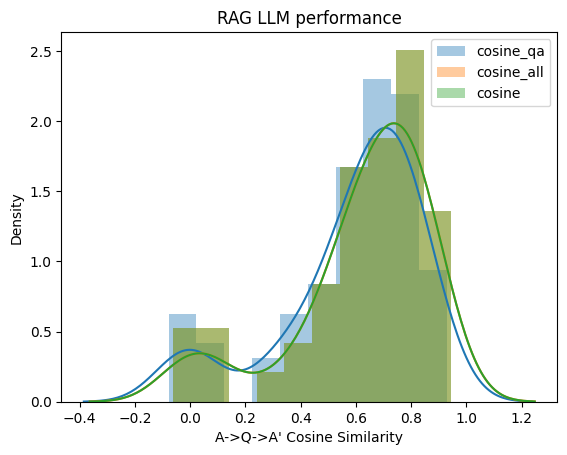

In [76]:
sns.distplot(df_results_llama['cosine_qa'], label='cosine_qa')
sns.distplot(df_results_llama['cosine_all'], label='cosine_all')
sns.distplot(df_results_llama['cosine'], label='cosine')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

### llama-3.1-8b-instant

In [82]:
answers = {}

In [83]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue
    #print(rec['question'])
    answer_llm = rag(rec['question'], llm_model="llama-3.1-8b-instant")
    doc_id = rec['doc_id']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'doc_id': doc_id,
        'question': rec['question'],
        'section': rec['section'],
    }

  0%|          | 0/95 [00:00<?, ?it/s]

In [100]:
df_results = pd.DataFrame(answers.values())#.sample(5).to_dict(orient='records')
#os.makedirs('data', exist_ok=True)
#df_results.to_csv('data/results_llama-3.1-8b-instant.csv', index=False)

In [ ]:
df_results = pd.read_csv('data/results_llama-3.3-70b-versatile.csv')

In [87]:
#df_results = df_results.to_dict(orient='records')

In [88]:
similarity = []

for record in tqdm(df_results):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/95 [00:00<?, ?it/s]

In [110]:
# df_results['cosine_all'] = similarity
# df_results['cosine_all'].describe()
df_results.groupby('section')['cosine_all'].describe()

,count,mean,std,min,25%,50%,75%,max
section,,,,,,,,
Education,10.0,0.551157,0.135180,0.209889,0.553061,0.581034,0.619167,0.677186
Projects,10.0,0.661562,0.228723,0.064837,0.647266,0.690888,0.764055,0.896328
Skills,5.0,0.473606,0.121589,0.315682,0.416995,0.483207,0.505718,0.646428
Work Experience,70.0,0.602707,0.209640,-0.045038,0.516511,0.639194,0.758682,0.930186


In [103]:
import pandas as pd
from tqdm import tqdm

def evaluate_rag_model(llm_model, ground_truth, doc_idx, rag, compute_similarity):
    """
    Evaluates a RAG model on a set of ground truth questions.
    
    Parameters:
        llm_model (str): The name of the LLM model to use.
        ground_truth (list): A list of records with 'question', 'doc_id', and 'section'.
        doc_idx (dict): A mapping from doc_id to original documents with 'text'.
        rag (function): The RAG function that accepts a question and llm_model, and returns an answer.
        compute_similarity (function): A function to compute similarity between RAG answer and ground truth.
    
    Returns:
        pd.DataFrame: DataFrame with questions, original answers, model answers, and similarity scores.
    """
    answers = {}

    for i, rec in enumerate(tqdm(ground_truth)):
        if i in answers:
            continue

        answer_llm = rag(rec['question'], llm_model=llm_model)
        doc_id = rec['doc_id']
        answer_orig = doc_idx[doc_id]['text']

        answers[i] = {
            'answer_llm': answer_llm,
            'answer_orig': answer_orig,
            'doc_id': doc_id,
            'question': rec['question'],
            'section': rec['section'],
        }

    df_results = pd.DataFrame(answers.values())

    similarity = []
    for _, record in tqdm(df_results.iterrows(), total=len(df_results)):
        sim = compute_similarity(record)
        similarity.append(sim)

    df_results['cosine_all'] = similarity
    return df_results


### gemma2-9b-it

In [104]:
df_gemma2 = evaluate_rag_model(
    llm_model="gemma2-9b-it",
    ground_truth=ground_truth,
    doc_idx=doc_idx,
    rag=rag,
    compute_similarity=compute_similarity
)

100%|██████████| 95/95 [00:08<00:00, 11.09it/s]


In [119]:
df_gemma2.to_csv('data/results_gemma2-9b-it.csv', index=False)

In [106]:
#df_gemma2['cosine_all'].describe()
df_gemma2.groupby('section')['cosine_all'].describe()

,count,mean,std,min,25%,50%,75%,max
section,,,,,,,,
Education,10.0,0.503161,0.223358,0.090166,0.337843,0.563621,0.665644,0.763620
Projects,10.0,0.694199,0.207173,0.218855,0.679453,0.775053,0.814077,0.868046
Skills,5.0,0.460016,0.157854,0.218194,0.432589,0.475481,0.523666,0.650151
Work Experience,70.0,0.625984,0.320942,-0.061153,0.459322,0.712221,0.865900,1.000000


C:\Users\Nida Khan\AppData\Local\Temp\ipykernel_22856\3868433039.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results_llama['cosine_all'], label='llama-3.1-70b-versatile')
C:\Users\Nida Khan\AppData\Local\Temp\ipykernel_22856\3868433039.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distpl

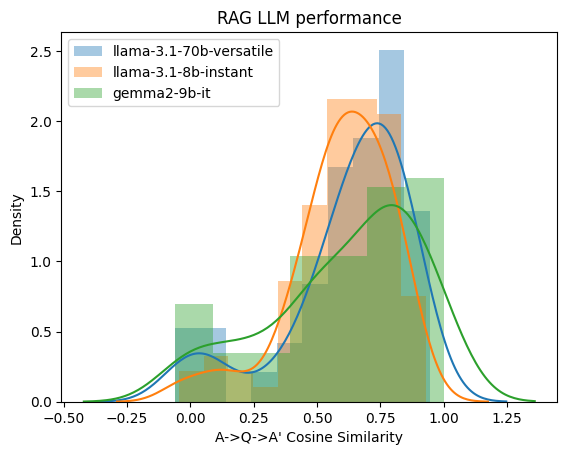

In [118]:
sns.distplot(df_results_llama['cosine_all'], label='llama-3.1-70b-versatile')
sns.distplot(df_results['cosine_all'], label='llama-3.1-8b-instant')
sns.distplot(df_gemma2['cosine_all'], label='gemma2-9b-it')
#sns.distplot(df_mistral['cosine_all'], label='mistral-saba-24b')
#sns.distplot(df_results_llama['cosine'], label='cosine')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

### mistral-saba-24b

In [113]:
df_mistral = evaluate_rag_model(
    llm_model="mistral-saba-24b",
    ground_truth=ground_truth,
    doc_idx=doc_idx,
    rag=rag,
    compute_similarity=compute_similarity
)

100%|██████████| 95/95 [00:09<00:00,  9.90it/s]


In [116]:
#df_mistral['cosine_all'].describe()
df_mistral.groupby('section')['cosine_all'].describe()

,count,mean,std,min,25%,50%,75%,max
section,,,,,,,,
Education,10.0,0.485864,0.267860,-0.000942,0.408138,0.557300,0.655563,0.813223
Projects,10.0,0.579671,0.365061,0.064837,0.204946,0.753559,0.846295,0.940708
Skills,5.0,0.464904,0.176297,0.202122,0.395336,0.480490,0.620331,0.626238
Work Experience,70.0,0.517540,0.312955,-0.061153,0.352017,0.602853,0.794357,0.951917


## LLM as-a-Judge

In [3]:
from rag_pipeline.rag import rag, vector_search, build_prompt, llm

In [5]:
from openai import OpenAI
from rag_pipeline.config import API_KEY, LLM_MODEL_DEFAULT

In [6]:
# openai api
OPENAI_API_KEY=os.environ.get("OPENAI_API_KEY")
openai_client = OpenAI(
    api_key=OPENAI_API_KEY
)

In [7]:
import pandas as pd
df_results_llama = pd.read_csv('data/results_llama-3.3-70b-versatile.csv')

In [8]:
prompt1_template = """
You are an expert evaluator for RAG-generated answers.

Given:
- A question
- A generated answer
- The original resume information

Evaluate whether the answer is:
1. **Correct** – factually answers the question well
2. **Grounded** – based only on the resume info provided

Then assign a score using this rubric:

Score 2 = Answer is correct AND grounded  
Score 1 = Answer is either correct OR grounded (but not both)  
Score 0 = Answer is neither correct nor grounded

Also provide a short explanation.

Format your output as JSON without code blocks:
{{
  "score": 0 | 1 | 2,
  "explanation": "short justification"
}}

---

QUESTION:
{question}

ANSWER:
{answer_llm}

REFERENCE (Resume Entry):
{answer_orig}
""".strip()

In [9]:
df_results_llama.loc[0, 'question']

'What is your current job title and where do you work?'

In [10]:
pp = prompt1_template.format(
        question=df_results_llama.loc[0, "question"],
        answer_llm=df_results_llama.loc[0, "answer_llm"],
        answer_orig=df_results_llama.loc[0, "answer_orig"]
    )

In [11]:
openai_client.chat.completions.create(
                model='gpt-4o-mini',
                messages=[{"role": "user", "content": pp}]
            )

ChatCompletion(id='chatcmpl-BwDQkX80Z1yxsbf60S1v2k1G2WLHe', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{\n  "score": 2,\n  "explanation": "The answer is correct as it accurately states the job title and the company where the person works, and it is grounded in the provided resume information."\n}', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1753214350, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint=None, usage=CompletionUsage(completion_tokens=44, prompt_tokens=217, total_tokens=261, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

In [12]:
# response = openai_client.chat.completions.create(
#                 model='gpt-4o-mini',
#                 messages=[{"role": "user", "content": pp}]
#             )
# content = response.choices[0].message.content
# cc = json.loads(content)

In [13]:
import json

def evaluate_row(row):
    prompt = prompt1_template.format(
        question=row["question"],
        answer_llm=row["answer_llm"],
        answer_orig=row["answer_orig"]
    )
    
    # Call to openAI API
    try:
        response = openai_client.chat.completions.create(
                model='gpt-4o-mini',
                messages=[{"role": "user", "content": prompt}]
            )
        content = response.choices[0].message.content
        result = json.loads(content)

        return pd.Series({
            "score_llm_eval": result.get("score"),
            "judge_explanation": result.get("explanation")
        })

    except Exception as e:
        return pd.Series({
            "score_llm_eval": None,
            "judge_explanation": f"Error: {str(e)}"
        })


In [14]:
from tqdm.notebook import tqdm
tqdm.pandas()

df_results_llama[["score_llm_eval", "judge_explanation"]] = df_results_llama.progress_apply(evaluate_row, axis=1)

  0%|          | 0/95 [00:00<?, ?it/s]

In [16]:
# for llama-3.3-70b-versatile only, (gpt 40 mini used as llm judge)
df_results_llama['score_llm_eval'].value_counts()

score_llm_eval
2    70
1    18
0     7
Name: count, dtype: int64

In [57]:
df_results_llama.head()#['score_llm_eval'].value_counts()

,answer_llm,answer_orig,doc_id,question,section,cosine,score_llm_eval,judge_explanation
0,"Your current job title is Data Scientist, and ...","Work Experience\nSecuriti, Karachi, Pakistan\t...",ae0142cf-58e4-408a-b2c3-950b9864f8e9,What is your current job title and where do yo...,Work Experience,0.782146,2,The answer correctly states that the current j...
1,The location of your current workplace is Kara...,"Work Experience\nSecuriti, Karachi, Pakistan\t...",ae0142cf-58e4-408a-b2c3-950b9864f8e9,Can you tell me about the location of your cur...,Work Experience,0.760741,2,The answer accurately states the location of t...
2,The candidate started their current position a...,"Work Experience\nSecuriti, Karachi, Pakistan\t...",ae0142cf-58e4-408a-b2c3-950b9864f8e9,When did you start your current position?,Work Experience,0.588890,2,The answer correctly states the start date of ...
3,"Yes, according to the resume, the candidate is...","Work Experience\nSecuriti, Karachi, Pakistan\t...",ae0142cf-58e4-408a-b2c3-950b9864f8e9,Are you currently working as a Data Scientist?,Work Experience,0.724143,2,The answer is correct because it accurately st...
4,The company you are employed with at the momen...,"Work Experience\nSecuriti, Karachi, Pakistan\t...",ae0142cf-58e4-408a-b2c3-950b9864f8e9,What company are you employed with at the moment?,Work Experience,0.582434,2,The answer is correct because it states the cu...


# Evaluate Retrieval

## Hit@K (Retrieval)

In [31]:
# if you included doc_id in the payload during qdratn_setup step, doc_id is more robust:
# in qdrant_setup:
# point = models.PointStruct(
#     id=doc["id"],  # This is Qdrant's internal ID
#     vector=models.Document(text=doc["text"], model=model_handle),
#     payload={
#         "text": doc["text"],
#         "section": doc["metadata"]["section"],
#         "doc_id": doc["id"]  ---> This makes it available in vector_search output
#     }
# )


# then you can match on doc_id instead:
# hit_scores = []

# for i, row in tqdm(df_results_llama.iterrows(), total=len(df_results_llama)):
    
#     question = row['question']
#     ground_truth_doc_id = row['doc_id']
#     # Get top-5 retrieved results
#     retrieved_docs = vector_search(question, limit=5)  # returns list of dicts with "doc_id"

#     # Check if the correct doc_id is among them
#     retrieved_ids = [doc['doc_id'] for doc in retrieved_docs]
#     hit = int(ground_truth_doc_id in retrieved_ids)

#     hit_scores.append(hit)

# # Compute Hit@5
# hit_at_5 = sum(hit_scores) / len(hit_scores)
# print(f"Hit@5: {hit_at_5:.3f}")


In [29]:
from tqdm import tqdm

hit_scores = []

for i, row in tqdm(df_results_llama.iterrows(), total=len(df_results_llama)):
    question = row['question']
    true_text = row['answer_orig'].strip()

    retrieved = vector_search(question, limit=5)
    retrieved_texts = [doc.get('text', '').strip() for doc in retrieved]

    # Compare true answer against top-5 retrieved
    hit = int(true_text in retrieved_texts)
    hit_scores.append(hit)

df['hit@5'] = hit_scores
hit_at_5 = sum(hit_scores) / len(hit_scores)
print(f"Hit@5: {hit_at_5:.3f}")

Hit@5: 0.811


In [32]:
def compute_hit_k(df, k=5, vector_search_fn=None):
    """
    Computes Hit@k for a given dataframe using answer_orig as ground truth.
    
    Args:
        df (pd.DataFrame): DataFrame with 'question' and 'answer_orig' columns.
        k (int): Number of top results to check.
        vector_search_fn (callable): Function to retrieve top-k documents for a question.
    
    Returns:
        List[int]: 1 if correct doc in top-k, else 0.
    """
    hits = []
    for _, row in df.iterrows():
        question = row['question']
        answer = row['answer_orig'].strip()

        results = vector_search_fn(question, limit=k)
        retrieved_texts = [doc.get("text", "").strip() for doc in results]

        hit = int(answer in retrieved_texts)
        hits.append(hit)

    return hits

In [45]:
# for llama-3.3-70b-versatile
hit_at_1 = compute_hit_k(df_results_llama, k=1, vector_search_fn=vector_search)
hit_at_3 = compute_hit_k(df_results_llama, k=3, vector_search_fn=vector_search)
hit_at_5 = compute_hit_k(df_results_llama, k=5, vector_search_fn=vector_search)

In [46]:
import numpy as np
print(np.mean(hit_at_1))
print(np.mean(hit_at_3))
print(np.mean(hit_at_5))

0.6
0.7894736842105263
0.8105263157894737


## MRR@k (Rank)

In [47]:
def compute_mrr(df, vector_search_fn, k=5):
    scores = []
    for i, row in df.iterrows():
        retrieved_docs = vector_search_fn(row["question"], limit=k)
        gold = row["answer_orig"].strip()

        rank = 0
        for idx, doc in enumerate(retrieved_docs):
            retrieved_text = doc.get("text", "").strip()
            if retrieved_text == gold:
                rank = idx + 1
                break

        score = 1 / rank if rank > 0 else 0
        scores.append(score)

    return scores


In [48]:
mrr_at_5 = compute_mrr(df_results_llama, vector_search_fn=vector_search)
print(np.mean(mrr_at_5))

0.6907017543859648
